# Projet 6 - Etudiez la faisabilité d'un moteur de classification d'articles

In [1]:
!pip install nltk==3.6.5

In [2]:
#%pip install torch
#%pip install tensorflow_hub

In [3]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp --upgrade

In [4]:
import os, sys
from os import listdir

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download NLTK data files
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
#nltk.download('punkt')

# nltk.data.path.append("C:/Users/cosic/AppData/Roaming/nltk_data")

from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from transformers import BertTokenizer, BertModel
import torch

import tensorflow_hub as hub
import tensorflow as tf

# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
# from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout

# import keras_core as keras
# import keras_nlp

# print("TensorFlow version:", tf.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cosic\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cosic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cosic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\cosic\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
sns.set()

## Exploration initiale du dataset

In [6]:
# Load the dataset
file_path = '../Source/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
dataset = pd.read_csv(file_path)

print('DataSet Shape = {}'.format(dataset.shape))
print('DataSet Memory Usage = {:.2f} MB'.format(dataset.memory_usage().sum() / 1024**2))

DataSet Shape = (1050, 15)
DataSet Memory Usage = 0.11 MB


In [7]:
dataset.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [8]:
dataset.tail()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [9]:
dataset.sample(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
826,700dfd088162ea00deda33123cd7f2da,2015-12-29 05:07:38 +0000,http://www.flipkart.com/timex-ti000i70600-anal...,Timex TI000I70600 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Timex Wrist Watc...",WATDX7VGHZAP2GZG,3495.0,3125.0,700dfd088162ea00deda33123cd7f2da.jpg,False,Timex TI000I70600 Analog Watch - For Men - Bu...,3.7,3.7,NaN,"{""product_specification""=>[{""key""=>""Date Displ..."
124,640fd08bb3ba538d67a5c0c2c61a5c4c,2016-06-24 16:03:26 +0000,http://www.flipkart.com/sos-computrised-lcd-in...,SOS COMPUTRISED LCD INTRFERENTIAL UNIT-125PROG...,"[""Beauty and Personal Care >> Health Care >> H...",ELTEJXM48D3HAUFB,19500.0,17550.0,640fd08bb3ba538d67a5c0c2c61a5c4c.jpg,False,Specifications of SOS COMPUTRISED LCD INTRFERE...,No rating available,No rating available,SOS,"{""product_specification""=>[{""key""=>""Treatment ..."
119,db6c79a1d852944a89e157793f392d67,2016-05-12 14:18:51 +0000,http://www.flipkart.com/frenemy-mpad271-mousep...,FRENEMY MPAD271 Mousepad,"[""Computers >> Laptop Accessories >> Mouse Pad...",ACCEGCASDTW8AW4G,399.0,169.0,db6c79a1d852944a89e157793f392d67.jpg,False,Key Features of FRENEMY MPAD271 Mousepad smoot...,No rating available,No rating available,FRENEMY,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
192,b4ccd4c315d99edd7c00d015b714485a,2015-12-01 12:40:44 +0000,http://www.flipkart.com/famous-wheel-pizza-cut...,Famous Wheel Pizza Cutter,"[""Kitchen & Dining >> Kitchen Tools >> Kitchen...",PACECMKUR6SNQFNZ,399.0,299.0,b4ccd4c315d99edd7c00d015b714485a.jpg,False,Famous Wheel Pizza Cutter (Steel Pack of 1)\r\...,No rating available,No rating available,Famous,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
712,227fc5c4fca14c424ff33e40941d22fa,2016-01-01 19:37:22 +0000,http://www.flipkart.com/mykid-nappy/p/itme5282...,MyKid Nappy,"[""Baby Care >> Diapering & Potty Training >> N...",NPYE5282ZUBCWPKE,399.0,199.0,227fc5c4fca14c424ff33e40941d22fa.jpg,False,Flipkart.com is offering MyKid Nappy for only ...,No rating available,No rating available,MyKid,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
945,8026dc3e27e8e318cc7431a723f7ebc1,2016-01-01 13:15:34 +0000,http://www.flipkart.com/unnati-floral-double-b...,Unnati Floral Double Blanket Multicolor,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAE2EEAXYVGRQMR,2997.0,715.0,8026dc3e27e8e318cc7431a723f7ebc1.jpg,False,Buy Unnati Floral Double Blanket Multicolor at...,No rating available,No rating available,Unnati,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
818,7436c011ebdfd24b56a77893f210ed3b,2015-12-12 11:46:53 +0000,http://www.flipkart.com/raymond-abstract-singl...,Raymond Abstract Single Blanket Orange,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAE9CSTFZAMXSNE,4289.0,3860.0,7436c011ebdfd24b56a77893f210ed3b.jpg,False,Buy Raymond Abstract Single Blanket Orange at ...,No rating available,No rating available,Raymond,"{""product_specification""=>[{""key""=>""Machine Wa..."
739,52877a6306aef18af67ab54c8233c931,2016-04-21 16:46:08 +0000,http://www.flipkart.com/buyer-s-beach-bb349/p/...,Buyer's Beach BB349,"[""Kitchen & Dining >> Dinnerware & Crockery >>...",CNSEHWGRNCSHGNPC,999.0,449.0,52877a6306aef18af67ab54c8233c931.jpg,False,Buyer's Beach BB349 (Brown) Price: Rs. 449 Sty...,No rating available,No rating available,Buyer's Beach,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
240,7e4c1d31e279a700c6b8e66d820e8601,2015-12-01 12:40:44 +0000,http://www.flipkart.com/kosher-kadhai-5-l/p/it...,Kosher Kadhai 5 L,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",PTPEANCHNPTDUUQK,592.0,592.0,7e4c1d31e279a700c6b8e66d820e8601.jpg,False,Buy Kosher Kadhai 5 L for Rs.592 online. Koshe...,No rating available,No rating available,Kosher,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
978,

## Colonnes pertinentes

| Type d'information | Nom de la colonne       | Exemple (ligne 0)                                                                    |
| ------------------ | ----------------------- | ------------------------------------------------------------------------------------ |
| 📄 Texte           | `description`           | Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral... |
| 🖼️ Image (id.jpg)    | `image`                 | 55b85ea15a1536d46b7190ad6fff8ce7.jpg                                                 |
| 🏷️ Catégorie      | `product_category_tree` | \["Home Furnishing >> Curtains & Accessories >> Curtains"]                           |


## Verification de la disponibilite des images

In [10]:
def check_images(dataframe, column_image, folder_images):
    """
    Vérifie la disponibilité des fichiers image dans un dossier.

    Args:
        dataframe (pd.DataFrame): Le DataFrame contenant les noms d'images.
        column_image (str): Le nom de la colonne contenant les noms d'image.
        folder_images (str): Le chemin vers le dossier contenant les images.

    Returns:
        dict: Statistiques sur les images trouvées / manquantes.
        list: Liste des images manquantes.
    """
    avaible_images = set(os.listdir(folder_images))
    waiting_images = set(dataframe[column_image].dropna().unique())

    found_images = waiting_images & avaible_images
    missing_images = list(waiting_images - avaible_images)

    stats = {
        "total_demandées": len(waiting_images),
        "disponibles": len(found_images),
        "manquantes": len(missing_images),
        "pourcentage_disponibles": round(len(found_images) / len(waiting_images) * 100, 2)
    }

    return stats, missing_images

In [11]:
stats, missing_images = check_images(dataset, column_image="image", folder_images="../Source/Flipkart/Images")

In [12]:
stats

{'total_demandées': 1050,
 'disponibles': 1050,
 'manquantes': 0,
 'pourcentage_disponibles': 100.0}

### Nous constatons que l'ensemble des images sont presentes

## Regardons d'un peu plus pres les descriptions

In [13]:
doc = dataset.description.sample(1)
doc = doc.values[0]
doc

'Disney 98189 Analog Watch  - For Boys, Girls - Buy Disney 98189 Analog Watch  - For Boys, Girls  98189 Online at Rs.900 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [14]:
doc = doc.lower()
doc

'disney 98189 analog watch  - for boys, girls - buy disney 98189 analog watch  - for boys, girls  98189 online at rs.900 in india only at flipkart.com. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!'

In [15]:
tokens = word_tokenize(doc)
tokens

['disney',
 '98189',
 'analog',
 'watch',
 '-',
 'for',
 'boys',
 ',',
 'girls',
 '-',
 'buy',
 'disney',
 '98189',
 'analog',
 'watch',
 '-',
 'for',
 'boys',
 ',',
 'girls',
 '98189',
 'online',
 'at',
 'rs.900',
 'in',
 'india',
 'only',
 'at',
 'flipkart.com',
 '.',
 '-',
 'great',
 'discounts',
 ',',
 'only',
 'genuine',
 'products',
 ',',
 '30',
 'day',
 'replacement',
 'guarantee',
 ',',
 'free',
 'shipping',
 '.',
 'cash',
 'on',
 'delivery',
 '!']

In [16]:
len(tokens)

50

In [17]:
len(set(tokens))

32

In [18]:
def display_tokens_infos(tokens):
    """
    display information about corpus tokens
    """
    print(f"nb of tokens = {len(tokens)}")
    print(f"nb of unique tokens = {len(set(tokens))}")
    print(f"nb of stopwords = {len([t for t in tokens if t in stopwords.words('english')])}")

In [19]:
display_tokens_infos(tokens)

nb of tokens = 50
nb of unique tokens = 32
nb of stopwords = 8


## Essayons un autre tokenizer

In [20]:
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(doc)
display_tokens_infos(tokens)
print("//")
tokens = [t for t in tokens if t not in stopwords.words('english')]
display_tokens_infos(tokens)

nb of tokens = 40
nb of unique tokens = 30
nb of stopwords = 8
//
nb of tokens = 32
nb of unique tokens = 25
nb of stopwords = 0


### Le RegexTokenizer capture d'une meilleure facon les informations

## Nous allons passer au pretraitement du texte.
### Pour ca je vais creer une fonction qui va tenter de gerer plusieurs elements a partir de ce que nous avons essaye jusqu'alors

In [21]:
def text_cleaning(text, 
                  rejoin=True, 
                  lemm_or_stem='stem', 
                  list_rare_words=None, 
                  min_len_word=3, 
                  eng_words=None, 
                  extra_words=None):
    """
    Nettoie le texte en supprimant les caractères spéciaux, les chiffres, les espaces supplémentaires,
    et en convertissant le texte en minuscules.

    Args:
        text (str): Le texte à nettoyer.

    Returns:
        str: Le texte nettoyé.
    """
    # liste des mots uniques
    if not list_rare_words:
        list_rare_words = []
    
    # extra words
    if not extra_words:
        extra_words = []
    
    # mettre le text en minuscule
    text = text.lower().strip()

    # suppression des balises HTML
    text = re.sub(r'<.*?>', ' ', text)

    # suppression des caractères spéciaux et des chiffres
    text = re.sub(r'[^a-z\s]', ' ', text)

    # suppression des espaces supplémentaires
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenisation
    tokenizer = RegexpTokenizer(r'\w+')
    raw_tokens_list = tokenizer.tokenize(text)

    # suppression des stopwords
    stop_words = set(stopwords.words('english'))
    clean_tokens_list = [word for word in raw_tokens_list if word not in stop_words]

    # retier les tokens rares
    non_rare_tokens_list = [word for word in clean_tokens_list if word not in list_rare_words]

    # conservation uniquement des  mots de longueur > N
    more_than_N = [word for word in non_rare_tokens_list if len(word) >= min_len_word]

    # conservation uniquement des caractere alpha et non des numériques
    alpha_num = [word for word in more_than_N if word.isalpha()]
    
    # lemmatisation or stemming
    if lemm_or_stem == 'lem':
        lemmanizer = WordNetLemmatizer()
        trans_text = [lemmanizer.lemmatize(word) for word in alpha_num]
    else:
        stemmer = PorterStemmer()
        trans_text = [stemmer.stem(word) for word in alpha_num]
    
    # english
    if eng_words:
        eng_text = [word for word in trans_text if word in eng_words]
    else:
        eng_text = trans_text
    
    # retrait des extra words
    final = [word for word in eng_text if word not in extra_words]
    if rejoin:
        return ' '.join(final)
    
    return eng_text


### Test sur un echantillon du dataset

In [22]:
echantillon = dataset[['product_name', 'description']].head(5).copy()
echantillon['description_nettoyee'] = echantillon['description'].apply(text_cleaning)

In [23]:
echantillon

,product_name,description,description_nettoyee
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,key featur eleg polyest multicolor abstract ey...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,specif sathiya cotton bath towel bath towel re...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,key featur eurospa cotton terri face towel set...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,key featur santosh royal fashion cotton print ...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,key featur jaipur print cotton floral king siz...


Text(0, 0.5, 'Fréquence')

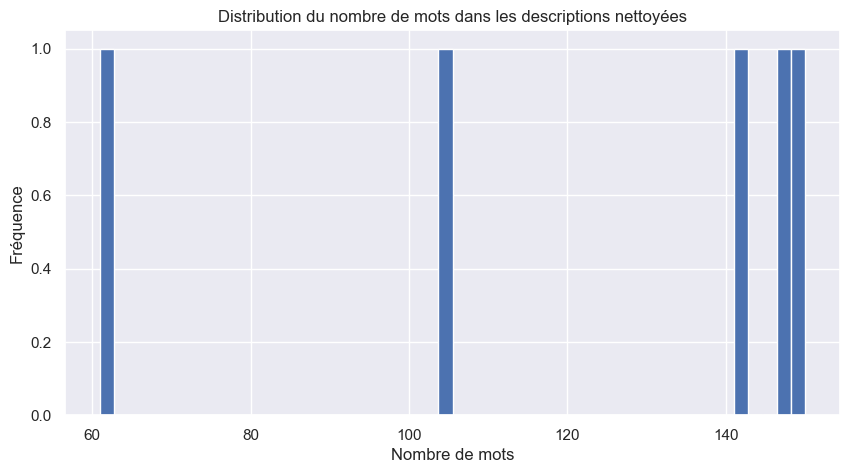

In [24]:
echantillon['description_nettoyee'].apply(lambda x: len(x.split(' '))).describe()
echantillon['description_nettoyee'].apply(lambda x: len(x.split(' '))).hist(bins=50, figsize=(10, 5))
plt.title('Distribution du nombre de mots dans les descriptions nettoyées')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')

## Essayons de traiter le corpus entierement

In [25]:
# assembler tous les corpus
raw_corpus = ' '.join(dataset.description.values)
raw_corpus  # Afficher les 1000 premiers caractères du corpus brut

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [26]:
len(raw_corpus)

498561

In [27]:
def process_text(doc, rejoin=False):
    """
    basic function to process text
    """
    doc = doc.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    raw_tokens = tokenizer.tokenize(doc)
    tokens = [t for t in raw_tokens if t not in stopwords.words('english')]
    if rejoin:
        return ' '.join(tokens)
    return tokens

In [28]:
corpus = process_text(raw_corpus)
display_tokens_infos(corpus)

nb of tokens = 61786
nb of unique tokens = 5966
nb of stopwords = 0


In [29]:
corpus

['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 '213',
 'cm',
 'height',
 'pack',
 '2',
 'price',
 'rs',
 '899',
 'curtain',
 'enhances',
 'look',
 'interiors',
 'curtain',
 'made',
 '100',
 'high',
 'quality',
 'polyester',
 'fabric',
 'features',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'makes',
 'room',
 'environment',
 'romantic',
 'loving',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'designs',
 'surreal',
 'attention',
 'sure',
 'steal',
 'hearts',
 'contemporary',
 'eyelet',
 'valance',
 'curtains',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'rays',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create

In [30]:
tmp = pd.Series(corpus).value_counts()
tmp

rs          911
products    631
free        618
buy         581
delivery    567
           ... 
656           1
motif         1
hargunz       1
driver        1
pgrn01        1
Name: count, Length: 5966, dtype: int64

In [31]:
tmp.describe()

count    5966.000000
mean       10.356353
std        39.975073
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       911.000000
Name: count, dtype: float64

<Axes: ylabel='count'>

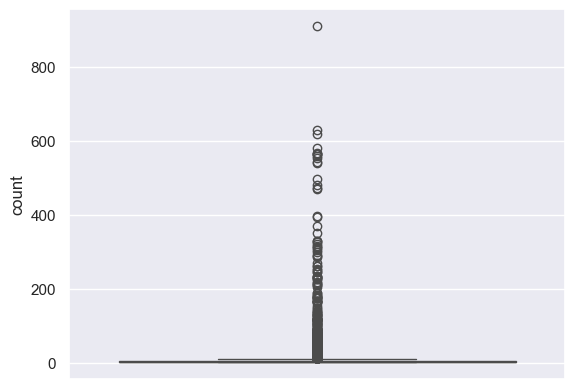

In [32]:
sns.boxplot(tmp)

## Nous allons appliquer notre cleaning sur l'ensemble de nos donnees

Text(0, 0.5, 'Fréquence')

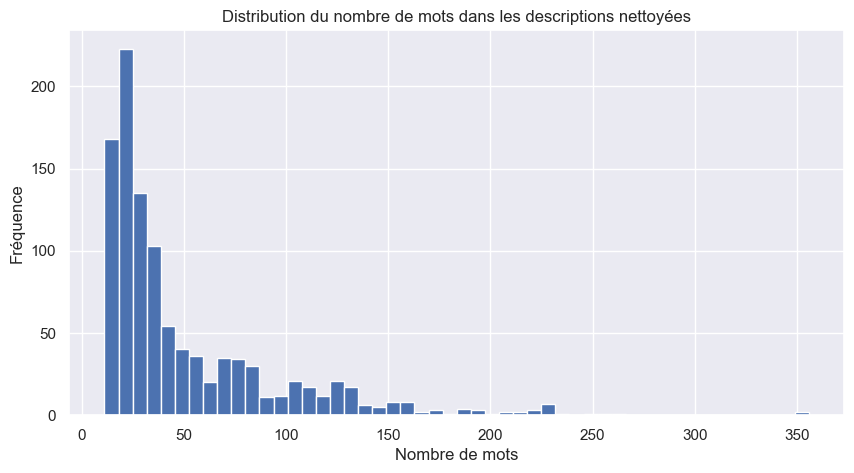

In [33]:
dataset['description_nettoyee_'] = dataset['description'].apply(text_cleaning)
dataset['description_nettoyee_'].apply(lambda x: len(x.split(' '))).describe()
dataset['description_nettoyee_'].apply(lambda x: len(x.split(' '))).hist(bins=50, figsize=(10, 5))
plt.title('Distribution du nombre de mots dans les descriptions nettoyées')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')

### On remarque meme que pour certains textes beaucoup de mots sont presents

# Nous allons passer maintenant a l'extraction des features texte et pour ca je vais utiliser deux approches que je pourrais comparer : type bag of words, comptage simple de mots et tf-idf

## Commencons par BoW - CountVectorizer

### L'objectif est de representer chaque description par un vecteur de comptage du nombre d'occurences de chaque mot dans le texte

In [34]:
# initialisation de notre vectoriseur BoW
vectorizer_bow = CountVectorizer(max_features=1000, stop_words='english')
# transformation de la colonne 'description_nettoyee_' en matrice BoW a partir de tous les mots presents dans le corpus
X_bow = vectorizer_bow.fit_transform(dataset['description_nettoyee_'])
# conversion en DataFrame
X_bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())
# voir le vocabulaire
words_bow = vectorizer_bow.get_feature_names_out()

print(f"Dimension matrice BoW = {X_bow.shape}")

Dimension matrice BoW = (1050, 1000)


In [35]:
X_bow_df

,aapno,abkl,abl,absorb,abstract,accessori,actual,adapt,adaptor,add,...,wool,work,world,woven,wow,wrap,ye,year,yellow,youth
0,0,0,0,0,4,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
words_bow

array(['aapno', 'abkl', 'abl', 'absorb', 'abstract', 'accessori',
       'actual', 'adapt', 'adaptor', 'add', 'addit', 'adhes', 'adjust',
       'ador', 'adorn', 'afford', 'age', 'air', 'akup', 'alarm', 'allin',
       'allow', 'almond', 'aloevera', 'aluminium', 'alway', 'amaz',
       'analog', 'android', 'angel', 'anim', 'anodis', 'anoth', 'anti',
       'antiqu', 'antiqueshop', 'apparel', 'appeal', 'appear', 'appl',
       'appli', 'applic', 'approx', 'arab', 'area', 'aroma', 'art',
       'artifici', 'artisan', 'artist', 'assembl', 'assort', 'assur',
       'asu', 'attach', 'attitud', 'attract', 'audio', 'authent', 'avail',
       'away', 'awesom', 'babi', 'backpack', 'bag', 'band', 'bank', 'bar',
       'base', 'basic', 'bath', 'batteri', 'bazaar', 'beauti', 'bed',
       'bedroom', 'bedsheet', 'beig', 'belt', 'best', 'bharatcraft',
       'big', 'birthday', 'black', 'blade', 'blanket', 'bleach', 'blend',
       'blue', 'bluetooth', 'board', 'bodi', 'bodysuit', 'bonsai',
       'b

## Maintenant essayons une autre methode comme Tf-idf - TfidfVectorizer (Term Frequency – Inverse Document Frequency)

### Comme avec BoW, mais cette fois ci on pondere les mots selon leur importance dans le corpus

In [37]:
# Initialisation de notre vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
# Transformation de la colonne 'description_nettoyee_' en matrice TF-IDF a partir de tous les mots presents dans le corpus
X_tfidf = vectorizer_tfidf.fit_transform(dataset['description_nettoyee_'])
# Conversion en DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
# Voir le vocabulaire
words_tfidf = vectorizer_tfidf.get_feature_names_out()

print(f"Dimension matrice TF-IDF = {X_tfidf.shape}")

Dimension matrice TF-IDF = (1050, 1000)


In [38]:
X_tfidf_df

,aapno,abkl,abl,absorb,abstract,accessori,actual,adapt,adaptor,add,...,wool,work,world,woven,wow,wrap,ye,year,yellow,youth
0,0.0,0.0,0.0,0.000000,0.18697,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.061627,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.077398,0.000000,0.197514,0.0
2,0.0,0.0,0.0,0.061451,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.046642,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.044327,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.036298,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1046,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.115219,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1047,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1048,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


### essayons de comparer les deux methodes sur les 10 premiers mots

In [39]:
for i in range(10):
    print(f"Mot {i+1:2} BoW : {words_bow[i]:15} | TF-IDF : {words_tfidf[i]}")

Mot  1 BoW : aapno           | TF-IDF : aapno
Mot  2 BoW : abkl            | TF-IDF : abkl
Mot  3 BoW : abl             | TF-IDF : abl
Mot  4 BoW : absorb          | TF-IDF : absorb
Mot  5 BoW : abstract        | TF-IDF : abstract
Mot  6 BoW : accessori       | TF-IDF : accessori
Mot  7 BoW : actual          | TF-IDF : actual
Mot  8 BoW : adapt           | TF-IDF : adapt
Mot  9 BoW : adaptor         | TF-IDF : adaptor
Mot 10 BoW : add             | TF-IDF : add


## A present nous devons tester une autre approche de type word/sentence embedding classique (word2Vec, GloVe, FastText)

### A la difference de Tf-idf ou BoW, ces approches la de type embeddings permettent de :
- #### capturer la semantique, c'est a dire que les mots similaires sont proches dans l'espadce vectoriel
- #### generer des vecteurs continus (reels), et non des vecteurs creux ou binaires
- #### creer des representations de phrases ou de documents en moyennant les vecteurs mots

## Word2Vec - Gensim

In [40]:
pip install --upgrade gensim


Note: you may need to restart the kernel to use updated packages.


In [41]:
from gensim.models import Word2Vec

In [42]:
# tokeniser chaque description nettoyée
dataset['tokens_'] = dataset['description_nettoyee_'].apply(word_tokenize)

In [43]:
# entrainer le modele Word2Vec
model_w2v = Word2Vec(sentences=dataset['tokens_'], vector_size=100, window=5, min_count=2, workers=4, sg=1)

In [44]:
# generer un vecteur par description (moyenne des vecteurs de mots)
def get_average_vector(tokens, model):
    """
    Calcule le vecteur moyen pour une liste de tokens en utilisant un modèle Word2Vec.
    """
    if not tokens:
        return np.zeros(model.vector_size)
    
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    
    return np.mean(vectors, axis=0)

In [45]:
dataset["embedding_w2v_"] = dataset['tokens_'].apply(lambda x: get_average_vector(x, model_w2v))
# Afficher les dimensions de l'embedding
print(f"Dimension de l'embedding Word2Vec = {dataset['embedding_w2v_'].iloc[0].shape}")

Dimension de l'embedding Word2Vec = (100,)


In [46]:
dataset["embedding_w2v_"].head()

0    [-0.0004419211, 0.15125571, -0.07645803, 0.010...
1    [0.030806432, 0.043556966, 0.013496991, -0.080...
2    [0.027457133, 0.059758835, -0.006618731, -0.03...
3    [-0.05280728, 0.029583845, -0.07495744, -0.088...
4    [-0.06529096, 0.052472167, -0.062781736, -0.08...
Name: embedding_w2v_, dtype: object

### Ici nous avons donc cree 1 vecteur pour chaque description

## Notre nouveau objectif est de realiser une fonction ajustable (pour n'importe quelle methode de vectorisation bof, tfidf, w2v, bert, use..) permettant d'extraire N features de texte (1 vecteur par description) puis appliquer des reductions de dimensionnalite (PCA - T-sne). Appliquer un KMeans sur les donnees reduites, calculer le score ARI entre les clusters KMeans et les categories reelles et enfin visualiser en 2D les points.

In [47]:
def features_retrieval_to_cluster(X_features, dataframe, methode=""):
    """
    Applique PCA + t-SNE + KMeans + ARI + Visualisation 2D sur une matrice de features.

    Args:
        X_features (np.ndarray or sparse matrix): Matrice [n_samples, n_features] issue d'une vectorisation texte.
        dataframe (pd.DataFrame): DataFrame d'origine contenant les catégories réelles.
        methode (str): Nom de la méthode (pour l'affichage).
    """
    print(f"Méthode : {methode}")

    # Appliquer une PCA
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X_features)

    print(f"Dimension après PCA : {X_pca.shape}")

    # Appliquer un t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_pca)
    dataframe["tsne_1"] = X_tsne[:, 0]
    dataframe["tsne_2"] = X_tsne[:, 1]

    print(f"Dimension après t-SNE : {X_tsne.shape}")


    # Appliquer KMeans
    kmeans = KMeans(n_clusters=7, random_state=42)
    dataframe["cluster"] = kmeans.fit_predict(X_pca)

    print(f"Clusters trouvés : {dataframe['cluster'].nunique()}")

    # Calucler l'ARI
    if "category_simple" not in dataframe:
        print("Aucune catégorie réelle pour le calcul de l'ARI.")
        dataframe["category_simple"] = dataframe["product_category_tree"].str.extract(r'\["([^"]+)')
    ari = adjusted_rand_score(dataframe["category_simple"], dataframe["cluster"])
    print(f"Score ARI : {ari:.4f}")

    # Visualisation 2D
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=dataframe, x="tsne_1", y="tsne_2", hue="cluster", palette="tab10", alpha=0.7)
    plt.title(f"t-SNE projection + KMeans Clustering ({methode})")
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return ari

## Utilisation avec methode TF-IDF

Méthode : Tf-idf
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0193


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


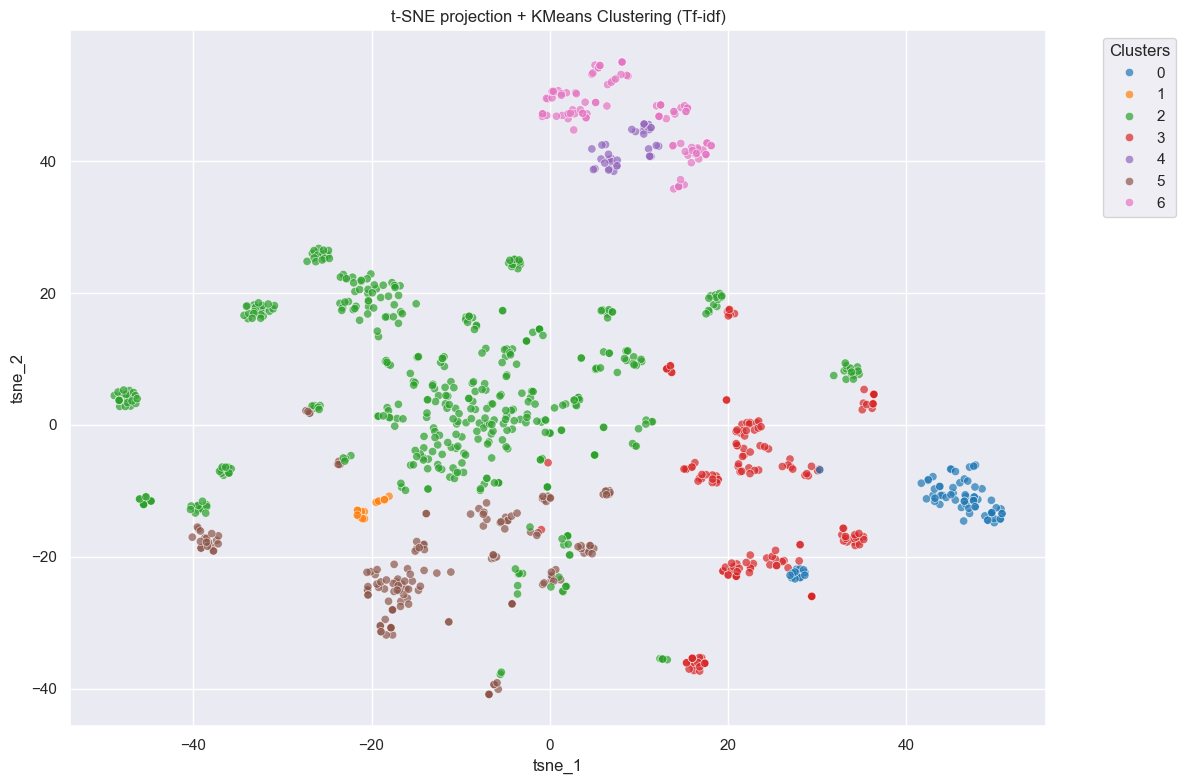

0.019325906749626257

In [48]:
# Exemple avec Tf-idf
X_tfidf = vectorizer_tfidf.fit_transform(dataset["description_nettoyee_"]).toarray()
features_retrieval_to_cluster(X_tfidf, dataset.copy(), methode="Tf-idf")

# Utilisation avec methode W2V

Méthode : Word2Vec
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0241


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


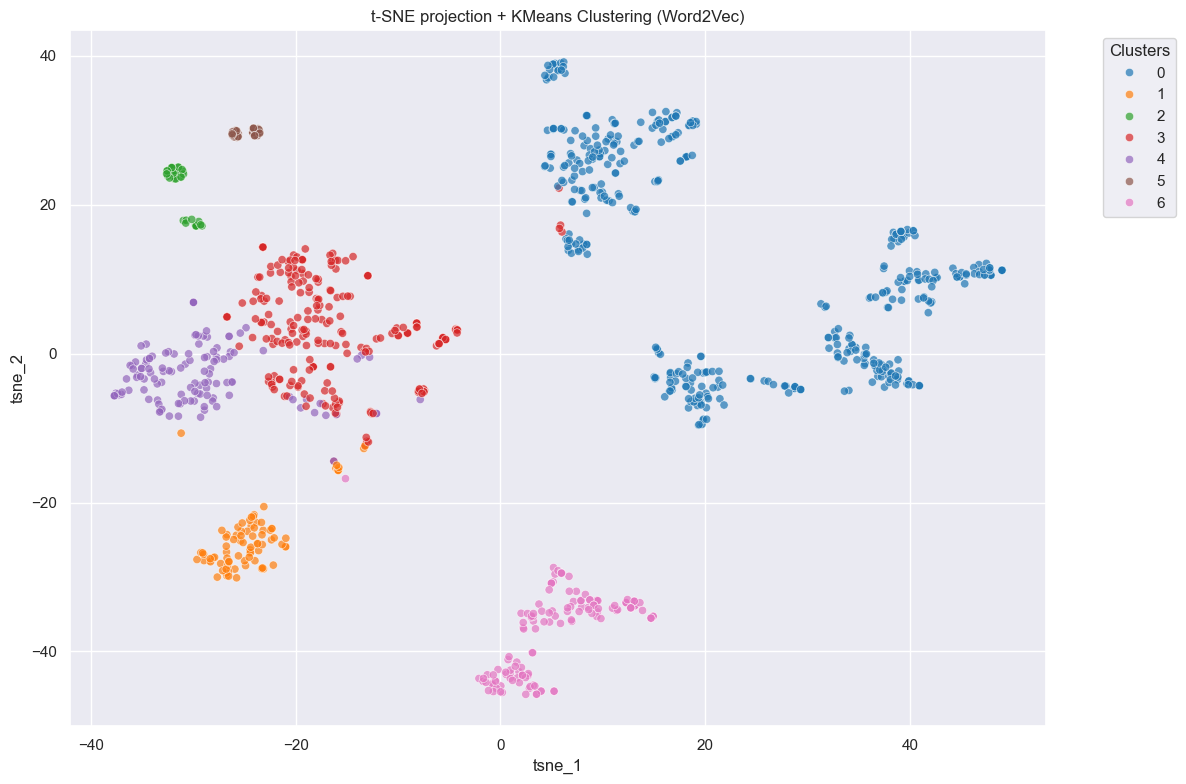

0.024084028878758604

In [49]:
# Exemple avec Word2Vec
X_w2v = np.vstack(dataset["embedding_w2v_"].values)
features_retrieval_to_cluster(X_w2v, dataset.copy(), methode="Word2Vec")

# Utilisation avec methode BERT

### Instnance du token bert + modele

In [50]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\cosic\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cosic\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

c:\Users\cosic\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Embedding bert

In [51]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # moyenne des tokens

In [52]:
dataset["embedding_bert_"] = dataset["description_nettoyee_"].apply(get_bert_embedding)
X_bert = np.vstack(dataset["embedding_bert_"])

Méthode : BERT
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0345


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


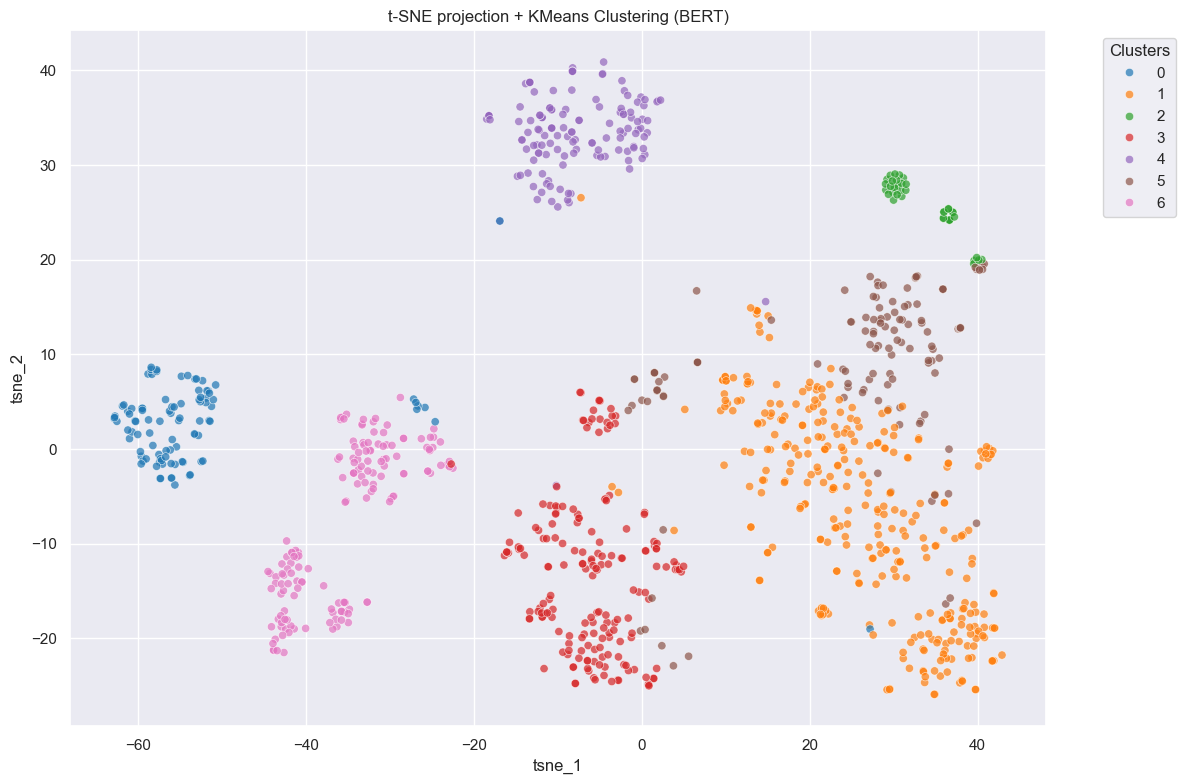

0.03447959979589417

In [55]:
features_retrieval_to_cluster(X_bert, dataset.copy(), methode="BERT")

# Utilisation avec methode USE

### Instance du modele USE

In [56]:
model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_use = model_use(dataset["description_nettoyee_"].tolist()).numpy()

Méthode : USE
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0360


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


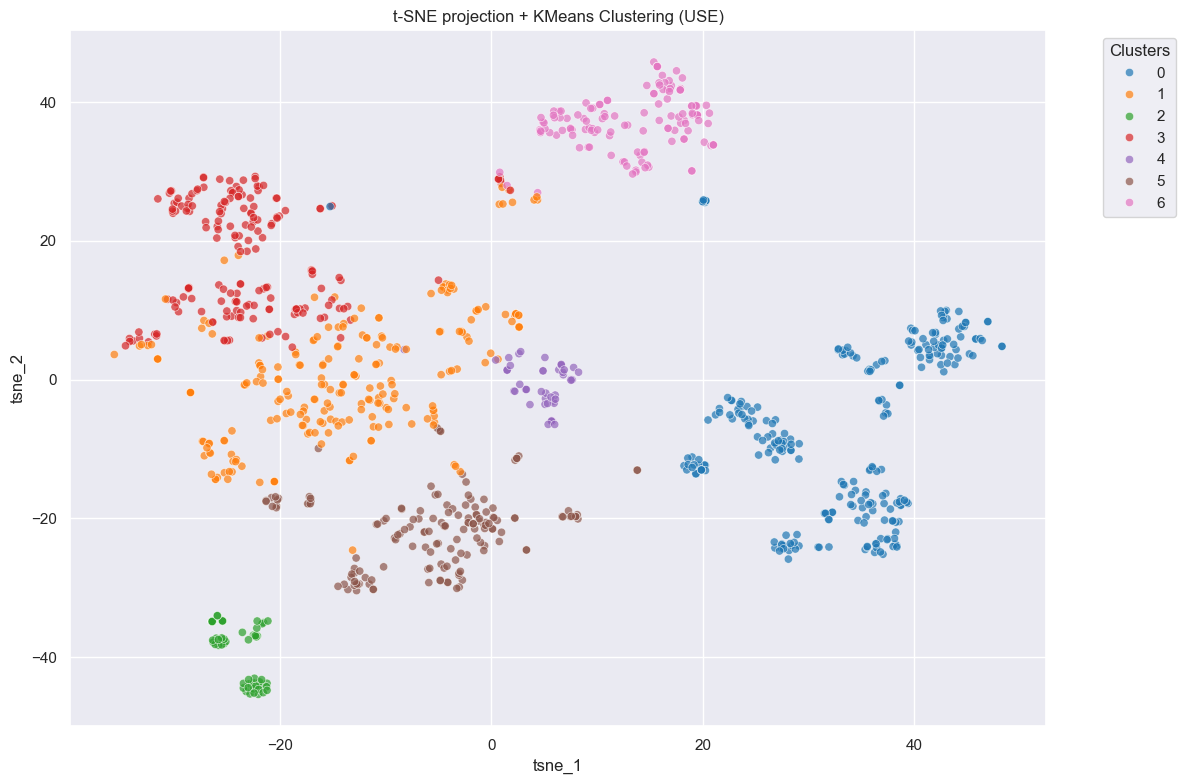

0.03596417537408043

In [57]:
features_retrieval_to_cluster(X_use, dataset.copy(), methode="USE")

## Enregistrons les resultats dans un tableau pour faire des comparratifs

In [58]:
def save_results(methode, ari, tableau):
    tableau.append({"Méthode": methode, "ARI": round(ari, 4)})
    return tableau

In [59]:
resultats_ari = []

Méthode : Tf-idf
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0193


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


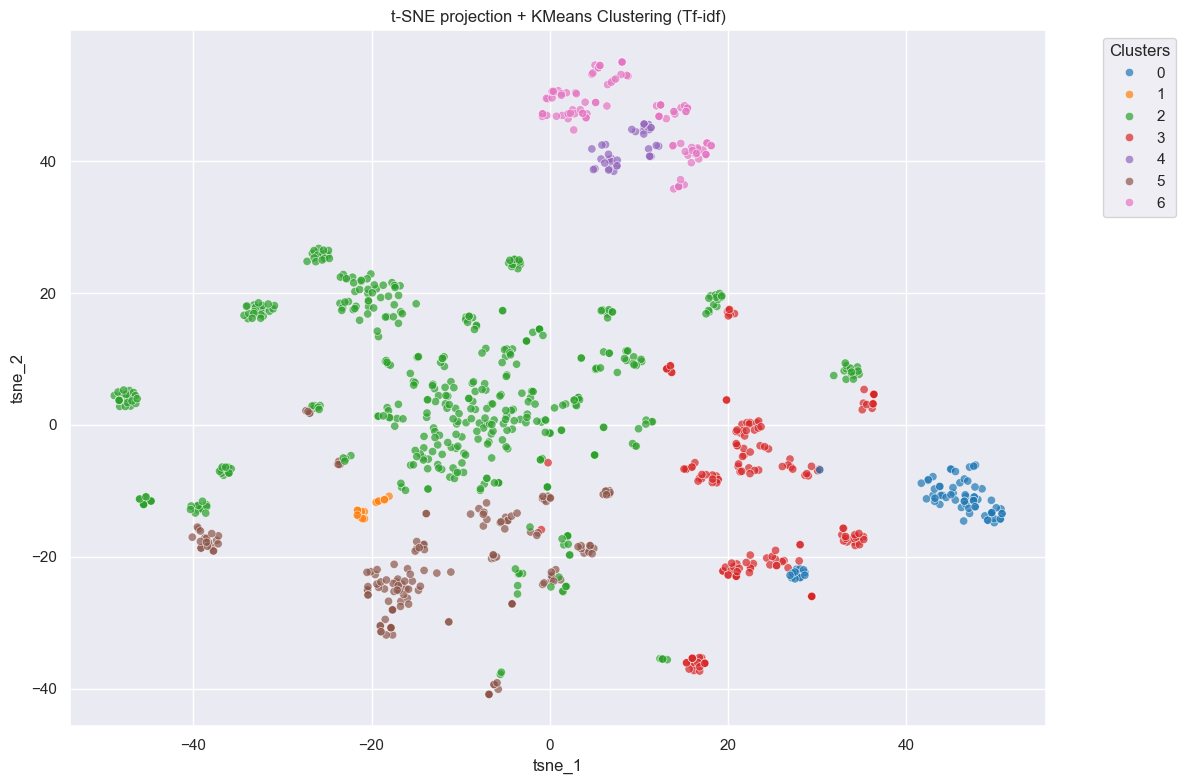

In [60]:
ari_tfidf = features_retrieval_to_cluster(X_tfidf, dataset.copy(), methode="Tf-idf")
resultats_ari = save_results("Tf-idf", ari_tfidf, resultats_ari)

Méthode : Word2Vec
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0241


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


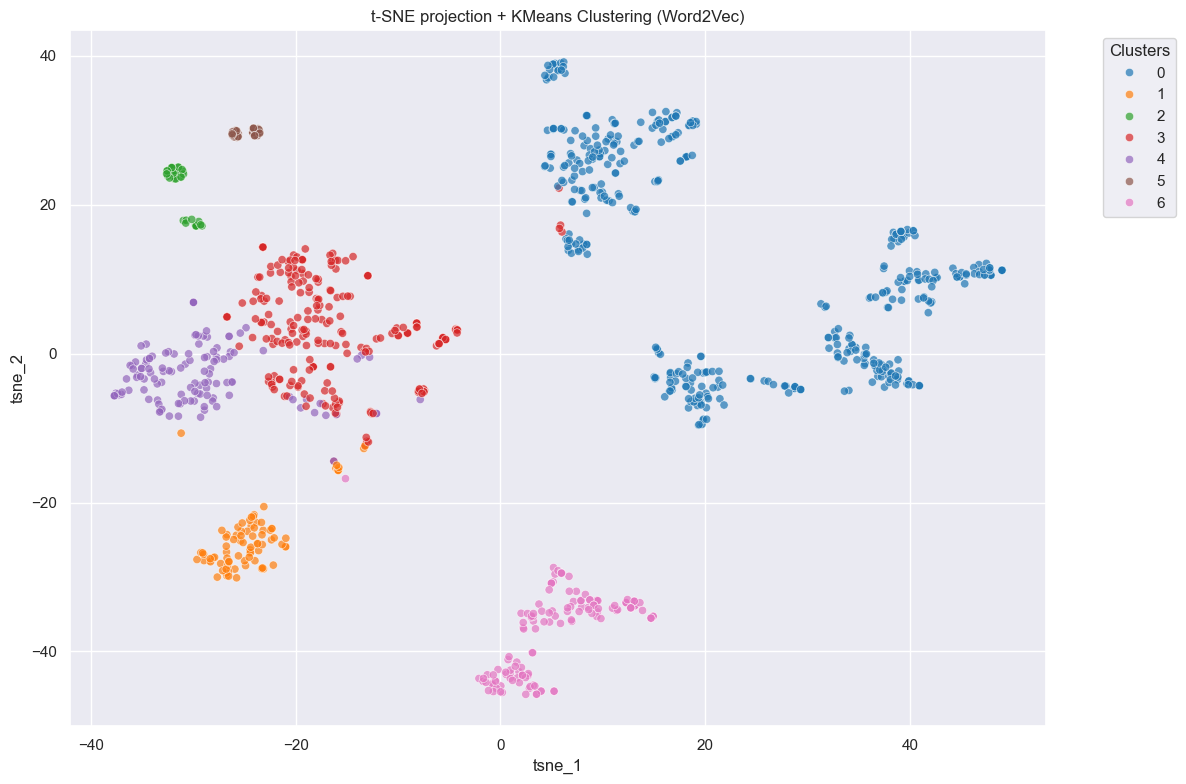

In [61]:
ari_w2v = features_retrieval_to_cluster(X_w2v, dataset.copy(), methode="Word2Vec")
resultats_ari = save_results("Word2Vec", ari_w2v, resultats_ari)

Méthode : BERT
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0345


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


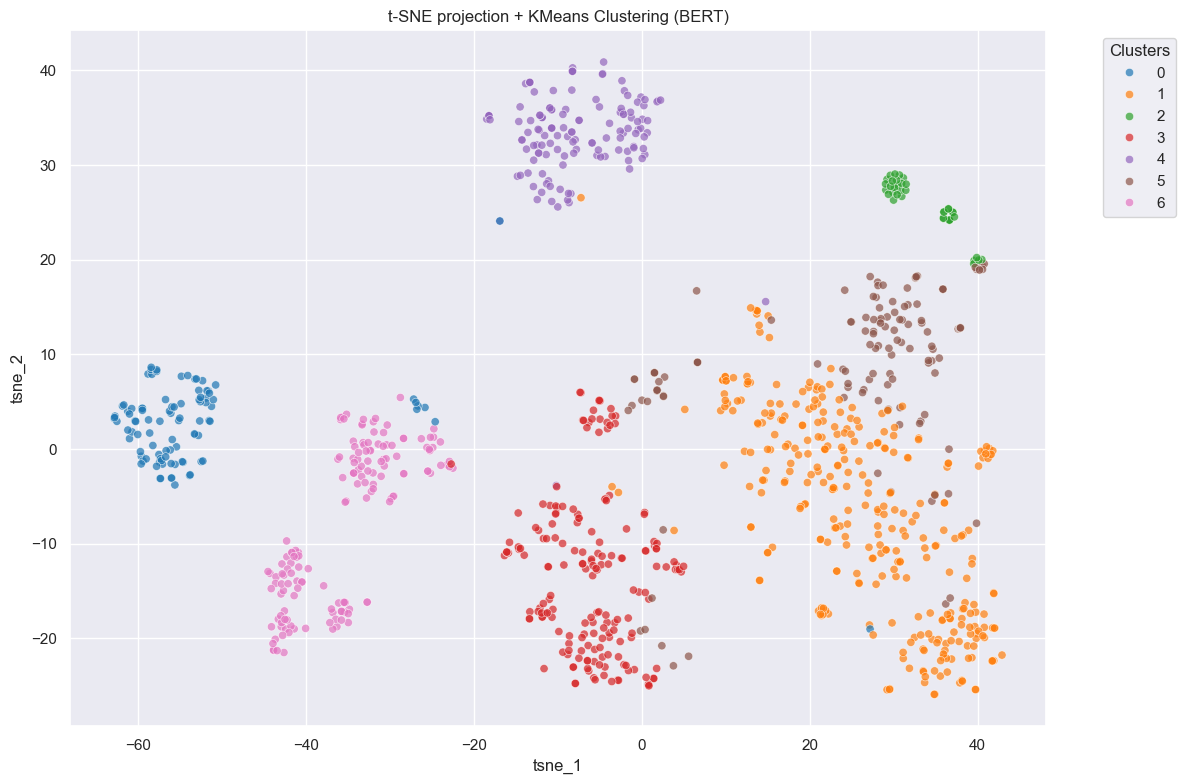

In [62]:
ari_bert = features_retrieval_to_cluster(X_bert, dataset.copy(), methode="BERT")
resultats_ari = save_results("BERT", ari_bert, resultats_ari)

Méthode : USE
Dimension après PCA : (1050, 50)
Dimension après t-SNE : (1050, 2)
Clusters trouvés : 7
Aucune catégorie réelle pour le calcul de l'ARI.
Score ARI : 0.0360


c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


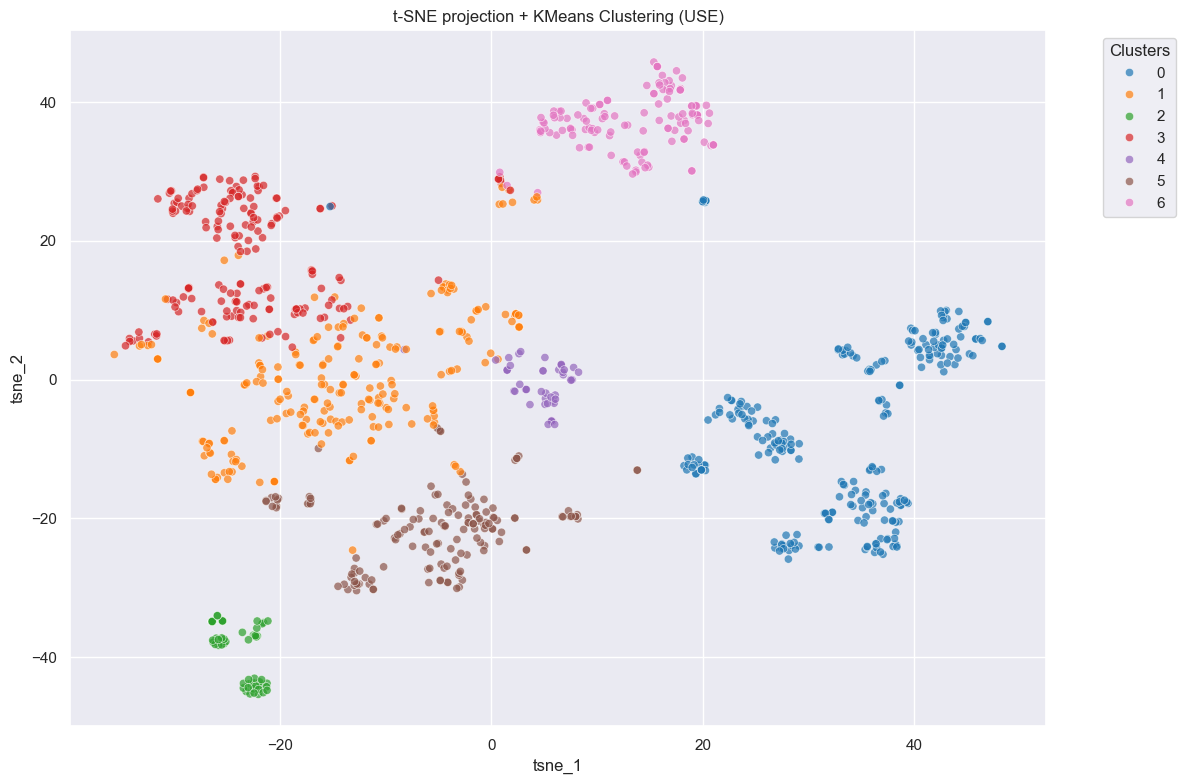

In [63]:
ari_use = features_retrieval_to_cluster(X_use, dataset.copy(), methode="USE")
resultats_ari = save_results("USE", ari_use, resultats_ari)

In [64]:
# Conversion en DataFrame
df_resultats = pd.DataFrame(resultats_ari)
df_resultats.sort_values(by="ARI", ascending=False, inplace=True)
print(df_resultats)

    Méthode     ARI
3       USE  0.0360
2      BERT  0.0345
1  Word2Vec  0.0241
0    Tf-idf  0.0193


## Visualisation du tableau 

C:\Users\cosic\AppData\Local\Temp\ipykernel_16532\4175095148.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultats, x="ARI", y="Méthode", palette="viridis")


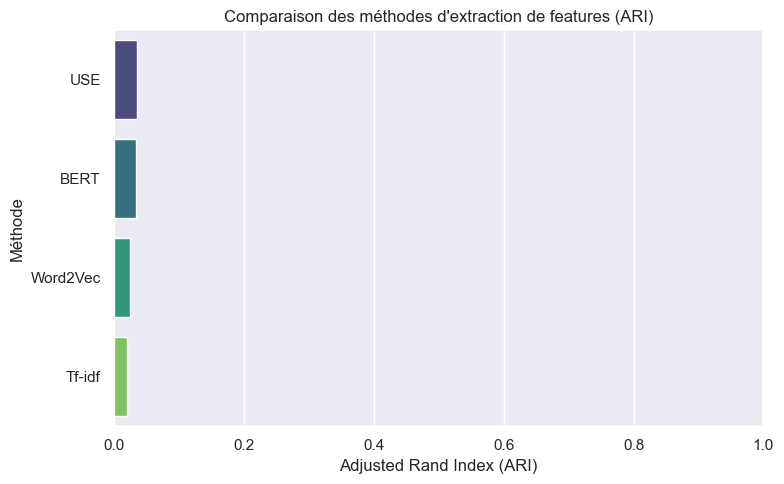

In [65]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultats, x="ARI", y="Méthode", palette="viridis")
plt.title("Comparaison des méthodes d'extraction de features (ARI)")
plt.xlabel("Adjusted Rand Index (ARI)")
plt.ylabel("Méthode")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()